# Using xarray for Image Processing
***
The purpose of this notebook is to show how to **read and process** research data images using the xarray library, with particular focus on Debye-Scherrer detector images, and extracting Intensity vs two-theta profiles from these images.

See xarray documentation here: (https://docs.xarray.dev/en/stable/index.html)

***
# General Imports
***

In [1]:
# We need to import some Python libraries here first.

import os
import sys
import shutil
import scipy

import numpy as np
import xarray as xr

import PIL # python image library for reading tiff files

In [2]:
# It would be good to have interactive plots if ipympl is installed.
# See: https://matplotlib.org/ipympl/

try:
    %matplotlib inline
except:
    %matplotlib widget

# importing matplotlib for plots.
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.constrained_layout.use'] = True

***
# Setting up the example data path
***

In [3]:
# We assume this notebook and its data is on Google Drive so that we can use Google Colab.
# Otherwise, replace example_data_path with the path the notebook and its data folder are stored on

try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/RTE-24-4876/code/pySULI-main/notebooks')
except:
    pass

In [4]:
# Assuming notebook and data folder are here.

here = os.getcwd()
example_data_path = 'example_data/file_types/image/'

os.chdir('%s/%s'%(here,example_data_path))
os.listdir()

['NIST-LaB6.tiff', 'NIST-LaB6.png', 'flower.jpg']

***
# Plotting a tiff image using numpy arrays
***

First, let's read a `.tiff` image in as a numpy array, and then plot it.

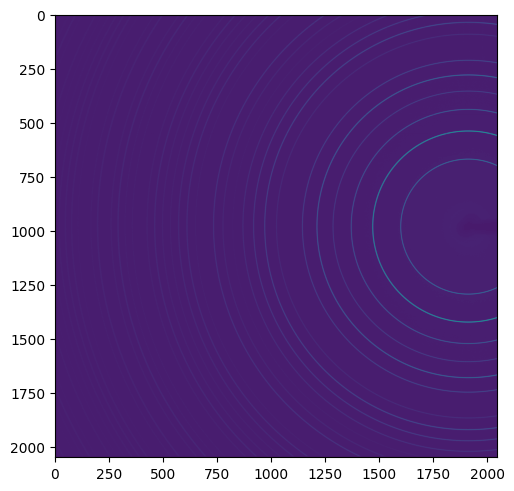

In [5]:
# first we need to read image as numpy array
img = np.array(PIL.Image.open('NIST-LaB6.tiff'))

# then plot using imshow
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(img)
ax.set_aspect('equal')

Although this method of plotting is fine, if you access the array later, without labeled dimensions it may take some effort to remember what is stored in the array and how exactly it is organized. The xarray Data Array addresses these concerns by allowing for dimensional information to be stored along with numerical data. 
***
# Reading a tiff image file and plotting with xarray.
***

The general motivation behind using xarray DataArrays for multidimensional arrays is that we can assign dimensions to our arrays. Also, when slicing, we can forget about the indexing going on in the background, and instead focus on the bounds on the dimensions dimensions in our slices. This will allow us to manipulate images in a straightforward manner, which we will look into later. 

Below we import the xarray as a numpy array, and then create a DataArray from it. Notice that we specify the `coords`, and `dims`, in addition to just the `data`.

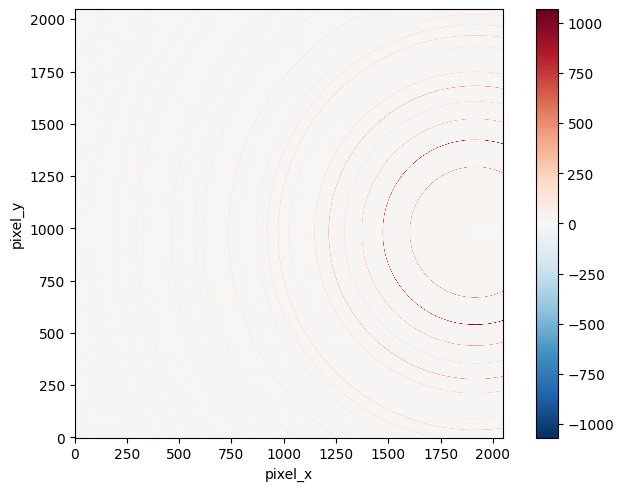

In [6]:
# first we need to read image as numpy array
img = np.array(PIL.Image.open('NIST-LaB6.tiff'))


# then we create an xarray DataArray object
da = xr.DataArray(data=img,
                  coords=[np.arange(img.shape[0]),np.arange(img.shape[1])],
                  dims=['pixel_y', 'pixel_x'])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
da.plot.imshow(ax=ax) # this line does the plotting for us and adds colorbar and figure axis labels.
ax.set_aspect('equal')

Let's compare what is stored within our numpy array object to what is stored in our DataArray object. Noticed that the DataArray object has the size of each dimension, and also arrays representing the `pixel_x` and `pixel_y` axes.

In [7]:
print("Image stored in numpy array:\n\n", img)

print('\n')

print("Image stored in DataArray array:\n\n", da)

Image stored in numpy array:

 [[ 0.  0. -1. ...  4.  5.  2.]
 [ 0.  0.  0. ...  4.  2.  4.]
 [ 0. -1.  0. ...  5.  2.  3.]
 ...
 [ 0.  0.  0. ... -2.  0.  1.]
 [ 0.  0.  1. ...  1.  0.  1.]
 [ 0.  0.  0. ...  2.  1. -1.]]


Image stored in DataArray array:

 <xarray.DataArray (pixel_y: 2048, pixel_x: 2048)>
array([[ 0.,  0., -1., ...,  4.,  5.,  2.],
       [ 0.,  0.,  0., ...,  4.,  2.,  4.],
       [ 0., -1.,  0., ...,  5.,  2.,  3.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  0.,  1.],
       [ 0.,  0.,  1., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  2.,  1., -1.]], dtype=float32)
Coordinates:
  * pixel_y  (pixel_y) int64 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047
  * pixel_x  (pixel_x) int64 0 1 2 3 4 5 6 ... 2042 2043 2044 2045 2046 2047


xarray plotting supports using a coloring scale `robust`, a great visual aide for examining 2d intensity plots. We utilize it by setting the argument `robust=True` in the `imshow()` method as shown below.

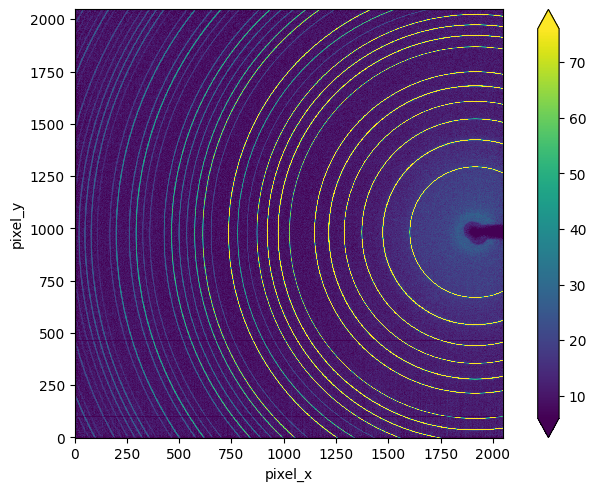

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
da.plot.imshow(ax=ax,robust=True)
ax.set_aspect('equal')

You can adjust the colormap with the `cmap` argument. The `vmin` and `vmax` arguments define the range of the colormap (which you can see in the bar on the right side of the plot).

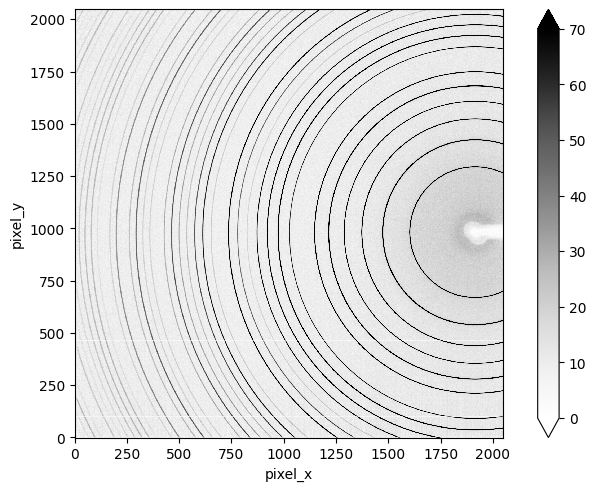

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
da.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70)
ax.set_aspect('equal')

Below we see our first evidence to use xarray instead of numpy arrays and matplotlib for making these kinds of plots: it is more complicated with numpy arrays. 

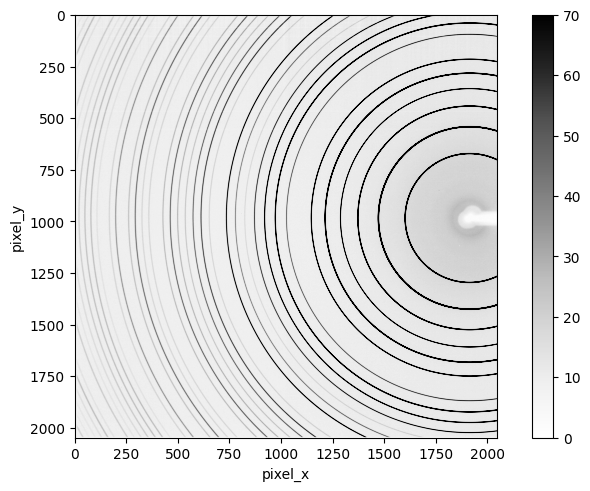

In [10]:
# in order to get the same plot as above, we need to add some stuff manually

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(img,vmin=0,vmax=70,cmap='Greys') # we learned to set 70 here from xarray plot

# --- xarray plotting does these for us automatically 
cb = fig.colorbar(im) 
ax.set_xlabel('pixel_x')
ax.set_ylabel('pixel_y')
# ---------------------------------------------------

ax.set_aspect('equal')

>NOTE: There are some detector defects on the image, which are visible in the xarray plot, but for whatever reason are not visible in the numpy plot.
For example, there are defective horizontal lines on pixel_x = 102 & pixel_y = 465 in the xarray plot, which are not visible in this numpy plot.

***
# Slicing with xarray DataArrays
***

Here is where xarray DataArray advantages over numpy arrays really shine through. Array slicing is as simply as you would expect it to be!

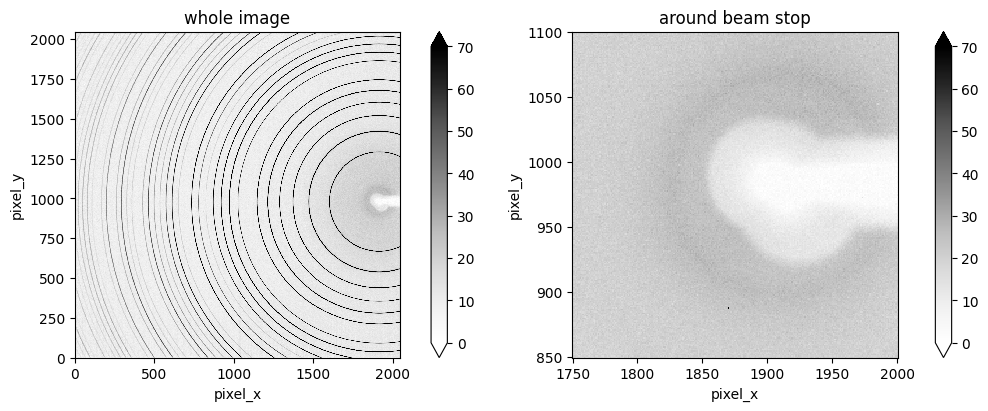

In [11]:
# The features around pixel_x=1910, pixel_y=980 come from the beam stop.
# We can easily zoom in those areas in a second plot.

fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(1,2,1)
da.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70)
ax.set_aspect('equal')
ax.set_title('whole image')


ax = fig.add_subplot(1,2,2)
da_sel = da.sel(pixel_x=slice(1750,2000)).sel(pixel_y=slice(850,1100))
da_sel.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70)
ax.set_aspect('equal')
ax.set_title('around beam stop');

Although we can also slice similarly with numpy, it is a lot less clear what we are doing, and the image is upside down for some reason! Also, in the slicing, the y-axis comes first, and the x-axis comes second. Also, the axes are not adjusted. Now we have to think about and adjust all these issues! Or we can just use xarray...

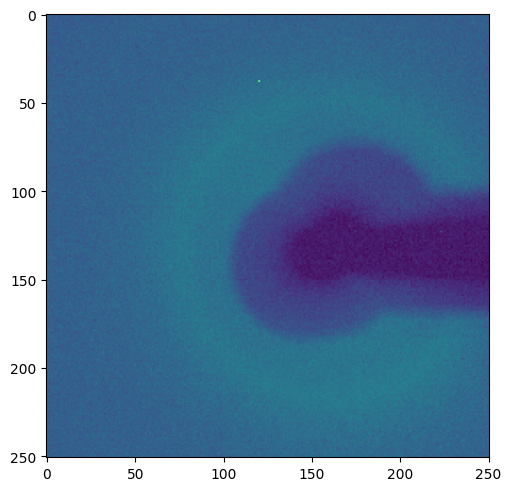

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# plotting the original numpy array along the same slice as for the xarray above 
ax.imshow(img[850:1101, 1750:2001])
ax.set_aspect('equal')

Let's zoom into another region to examine some detector artifacts.

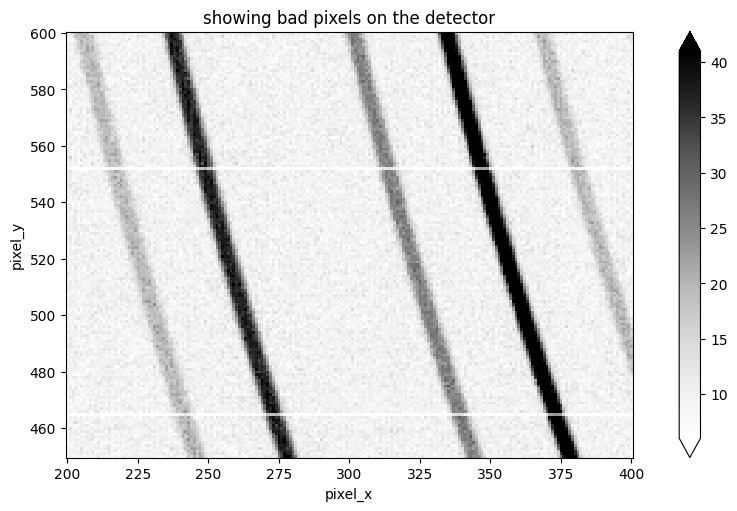

In [13]:
fig = plt.figure(figsize=(8,5))


ax = fig.add_subplot(1,1,1)
da_sel = da.sel(pixel_x=slice(200,400)).sel(pixel_y=slice(450,600))
da_sel.plot.imshow(ax=ax,robust=True,cmap = 'Greys')
ax.set_aspect('equal')
ax.set_title('showing bad pixels on the detector');

Now lets further zoom into one of these defects. If we take a vertical slice, we see a clear drop in intensity in the center, which should not be there; evidence that we have a defect.

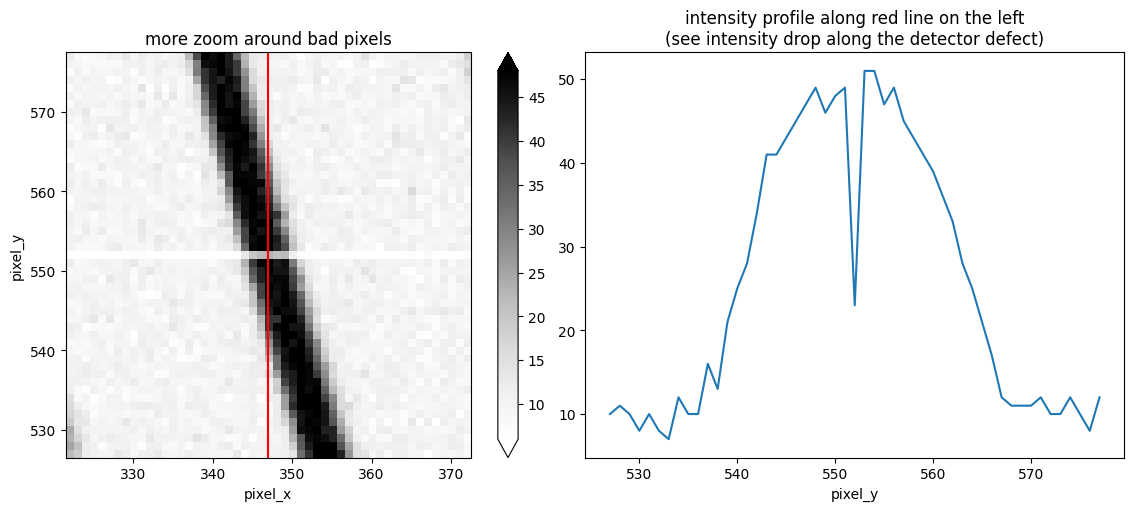

In [14]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,2,1)
da_sel = da.sel(pixel_x=slice(347-25,347+25)).sel(pixel_y=slice(552-25,552+25))
da_sel.plot.imshow(ax=ax,robust=True,cmap = 'Greys')
ax.axvline(x=347,color='r')
ax.set_aspect('equal')
ax.set_title('more zoom around bad pixels')

ax = fig.add_subplot(1,2,2)
da_sel.sel(pixel_x=347,method='nearest').plot()
ax.set_title('intensity profile along red line on the left\n(see intensity drop along the detector defect)');

> Notice that array slicing allows us to effectively zoom in on specific parts of an image.

***
# Slicing to extract an intensity profile
***
Now, let's look into extracting an intensity profile from this Debye-Scherre ring pattern. There are other tools (which we will get to later) that do this for you, but here we exibit the functionality of xarray.

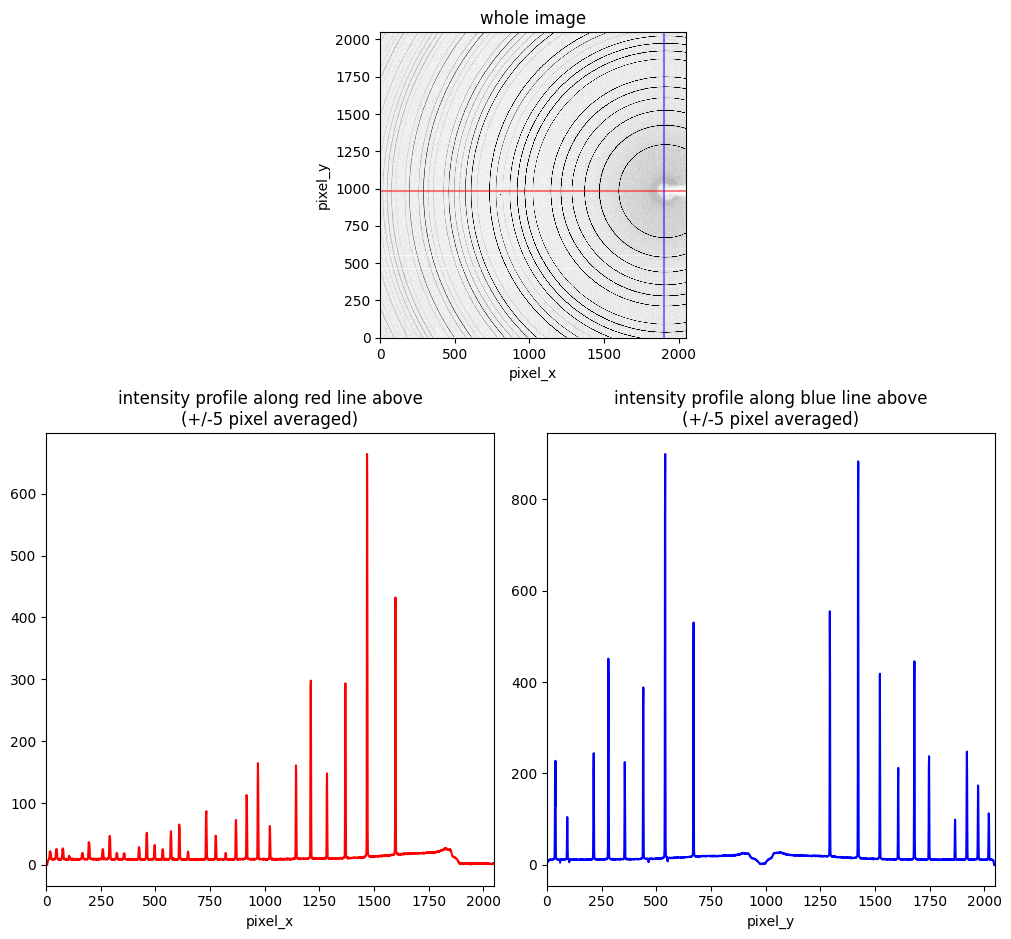

In [15]:
# This is similar way of selecting and averaging profile

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(2,3,2)
da.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70,add_colorbar=False)
ax.axhline(y=983,color='r',alpha=0.5)
ax.axvline(x=1900,color='b',alpha=0.5)
ax.set_aspect('equal')
ax.set_title('whole image')


ax = fig.add_subplot(2,2,3)
da_sel = da.sel(pixel_y=slice(983-5,983+5)).mean(dim='pixel_y') # here we first select and then average
da_sel.plot(ax=ax,color='r')
ax.set_title('intensity profile along red line above\n(+/-5 pixel averaged)')
ax.set_xlim([0,2048])

ax = fig.add_subplot(2,2,4)
da_sel = da.sel(pixel_x=slice(1900-5,1900+5)).mean(dim='pixel_x') # here we first select and then average
da_sel.plot(ax=ax,color='b')
ax.set_title('intensity profile along blue line above\n(+/-5 pixel averaged)')
ax.set_xlim([0,2048]);

We can even get an intensity profile along an arbitrary line.

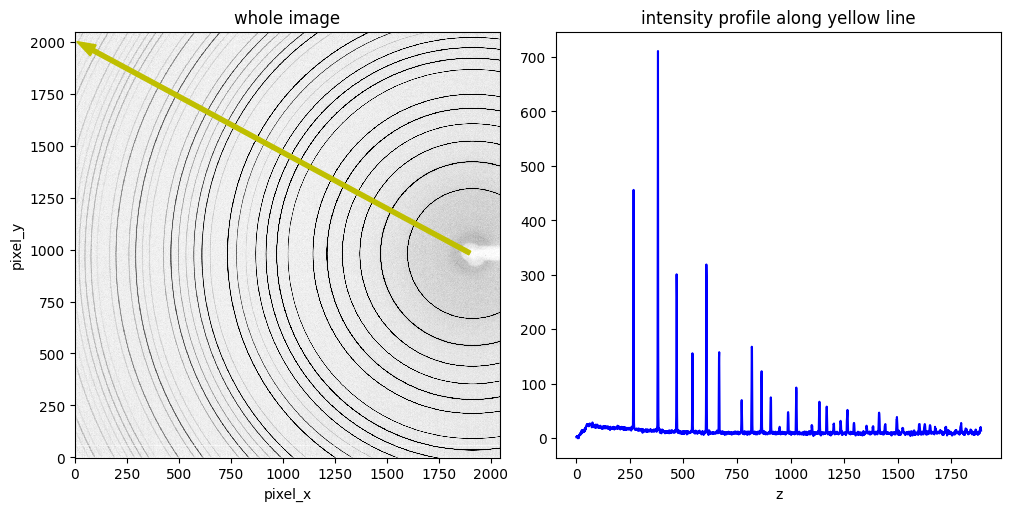

In [16]:
# this is more advanced way of getting line profile along yellow line below

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
da.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70,add_colorbar=False)

# poi
p1 = (1900,983) # the center of the pattern
p2 = (10,2000)
# arrow
ax.arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],width=20,color="y",length_includes_head=True)

ax.set_aspect('equal')
ax.set_title('whole image')



ax = fig.add_subplot(1,2,2)

from skimage.draw import line
# tuple storing x and y arrays representing corresponding x and y coordinates of our line
pline = line(p1[0],p1[1],p2[0],p2[1])
# creation of x_array from x coords of our line tuple
x = xr.DataArray(pline[0], dims="z")
# creation of x_array from y coords of our line tuple
y = xr.DataArray(pline[1], dims="z")
da_sel = da.interp(pixel_x=x,pixel_y=y)
da_sel.plot(ax=ax, color='b')

ax.set_title('intensity profile along yellow line');

We can also achieve this without using skimage, instead just using linear spaced lists to approximate the line. The skimage line isn't as "jagged" but as we can see, it doesn't make much of a difference

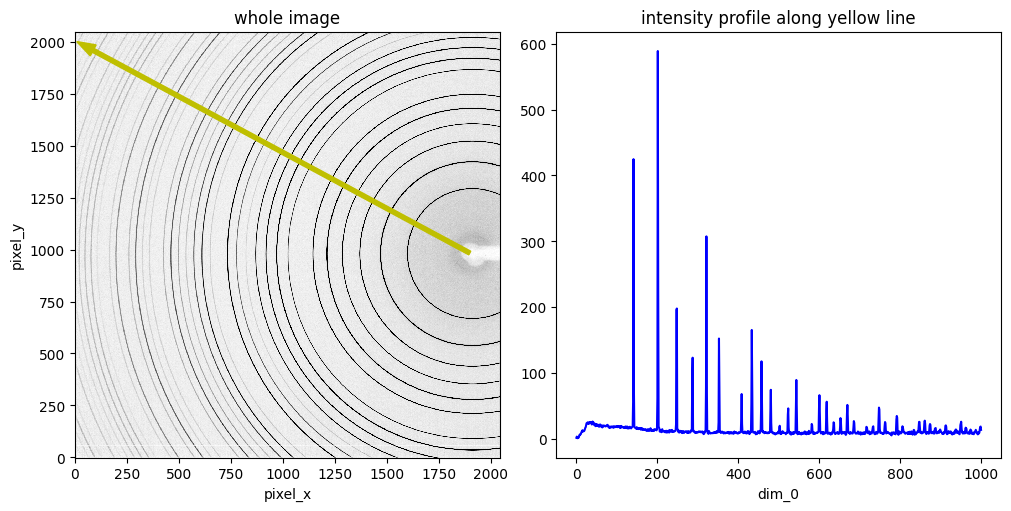

In [17]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
da.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70,add_colorbar=False)

# poi
p1 = (1900,983) # the center of the pattern
p2 = (10,2000)
# arrow
ax.arrow(p1[0],p1[1],p2[0]-p1[0],p2[1]-p1[1],width=20,color="y",length_includes_head=True)
ax.set_aspect('equal')
ax.set_title('whole image')




ax = fig.add_subplot(1,2,2)
da_int = da.interp(pixel_x=xr.DataArray(np.linspace(p1[0],p2[0],1000)),
                   pixel_y=xr.DataArray(np.linspace(p1[1],p2[1],1000)))
da_int.plot(ax=ax, color='b')

ax.set_title('intensity profile along yellow line');

Here is a simple azimuthal integrator written by <https://github.com/pmeshkov> & <https://github.com/KMorell>! It is inefficient and takes a bit to run, and also isn't that good of an integrator because it does not calibrate correctly. Soon we will see tools for doing this efficiently, and with less "eyeballing". Either way, this is a good piece of code to examine to get an idea for what's going on when you perform azymuthal integration using a tool like pyFAI.

In [18]:
# adjustment of previously used center to get real center
# as well as fixed radii for blue rings
actual_center = np.add(p1,(17,-3))
radius = 315
tolerance = 10
radius1 = 200#radius-tolerance
radius2 = 1800#radius+tolerance


from skimage.draw import circle_perimeter

# finding every point in the sliver of the circle

circle = 0
data_values = da.values
sum_list = []
average_intensity = []

for i in np.arange(radius1, radius2):
    circle = circle_perimeter(actual_center[0],actual_center[1],i)
    for j in np.arange(0,len(circle[0])):
        try:
            sum_list = np.append(sum_list,data_values[circle[1][j]][circle[0][j]])
        except:
            continue
    average_intensity = np.append(average_intensity,np.average(sum_list))
    sum_list = []
print("complete")

complete


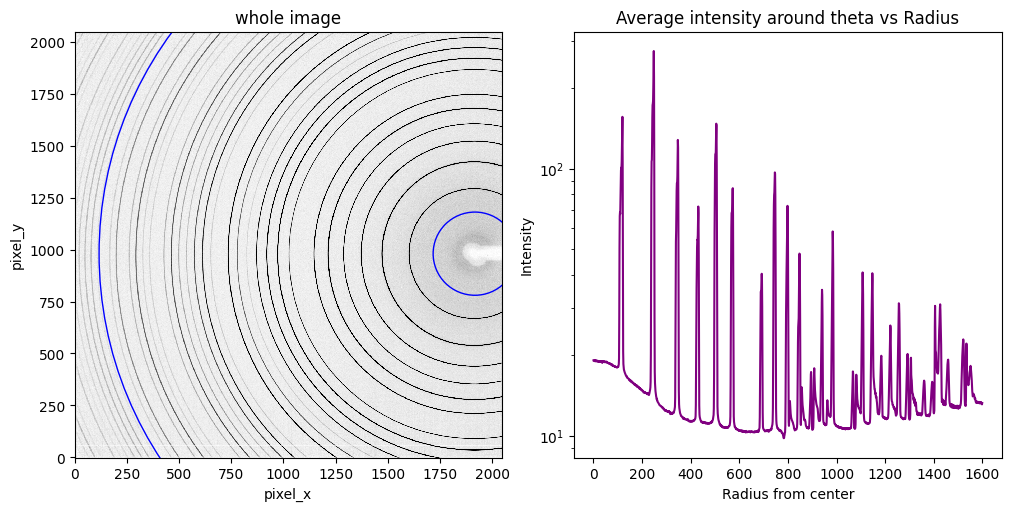

In [19]:
fig = plt.figure(figsize=(10,5))
# plot whole image
ax = fig.add_subplot(1,2,1)
da.plot.imshow(ax=ax,robust=True,cmap = 'Greys', vmin=0, vmax=70,add_colorbar=False)
ax.set_title('whole image')

circle1 = plt.Circle(actual_center, radius1, color='b', fill=False)
circle2 = plt.Circle(actual_center, radius2, color='b', fill=False)
ax.add_patch(circle1)
ax.add_patch(circle2)

intensity_xarray = xr.DataArray(average_intensity)

ax = fig.add_subplot(1,2,2)
intensity_xarray.plot(color='purple')
ax.set_xlabel("Radius from center")
ax.set_ylabel("Intensity")
ax.set_yscale('log')

ax.set_title('Average intensity around theta vs Radius');

***